# Full Trajectory Estimation

In [7]:
import os
import json
import numpy as np
import sympy as sp
import pyomo.environ as pyo
import matplotlib.pyplot as plt
from glob import glob
from time import time
from scipy.stats import linregress
from pyomo.opt import SolverFactory
from lib import misc, utils, app

plt.style.use(os.path.join('..', 'configs', 'mplstyle.yaml'))

%load_ext autoreload
%autoreload 2

ROOT_DATA_DIR = os.path.join('..', 'data')

In [8]:
## nptyping needs to be v1.0.1 for 'Array' class. Later versions use 'NDArray'
## data/2019_03_09/lily/run for DATA_DIR path needs to be manually downloaded from GitHub
## also 'extrinsic_calib' (download manually).
## environment missing 'opencv' and 'tables', needed to install those dependencies
## had to downgrade ipopt to version 3.11.1 

# Reconstruction params

In [9]:
DATA_DIR = os.path.join(ROOT_DATA_DIR, '2019_03_09', 'lily', 'run')

start_frame = 70
end_frame = 170 # use -1 to reconstruct up to the last frame possible

# DLC p_cutoff - any points with likelihood < dlc_thresh are not trusted in optimization
dlc_thresh = 0.5 # change this only if the optimization result is unsatisfactory

# Robust Cost Function

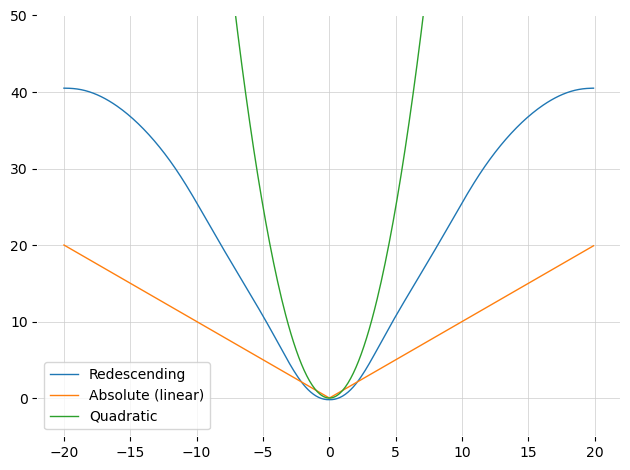

In [10]:
# PLOT OF REDESCENDING, ABSOLUTE AND QUADRATIC COST FUNCTIONS
# we use a redescending cost to stop outliers affecting the optimization negatively
redesc_a, redesc_b, redesc_c = 3, 10, 20

#Plot
r_x  = np.arange(-20,20, 1e-1)
r_y1 = [misc.redescending_loss(i, redesc_a, redesc_b, redesc_c) for i in r_x]
r_y2 = abs(r_x)
r_y3 = r_x**2
plt.figure()
plt.plot(r_x,r_y1, label='Redescending')
plt.plot(r_x,r_y2, label='Absolute (linear)')
plt.plot(r_x,r_y3, label='Quadratic')
ax = plt.gca()
ax.set_ylim((-5, 50))
ax.legend()
plt.show(block=False)

# Optimisation

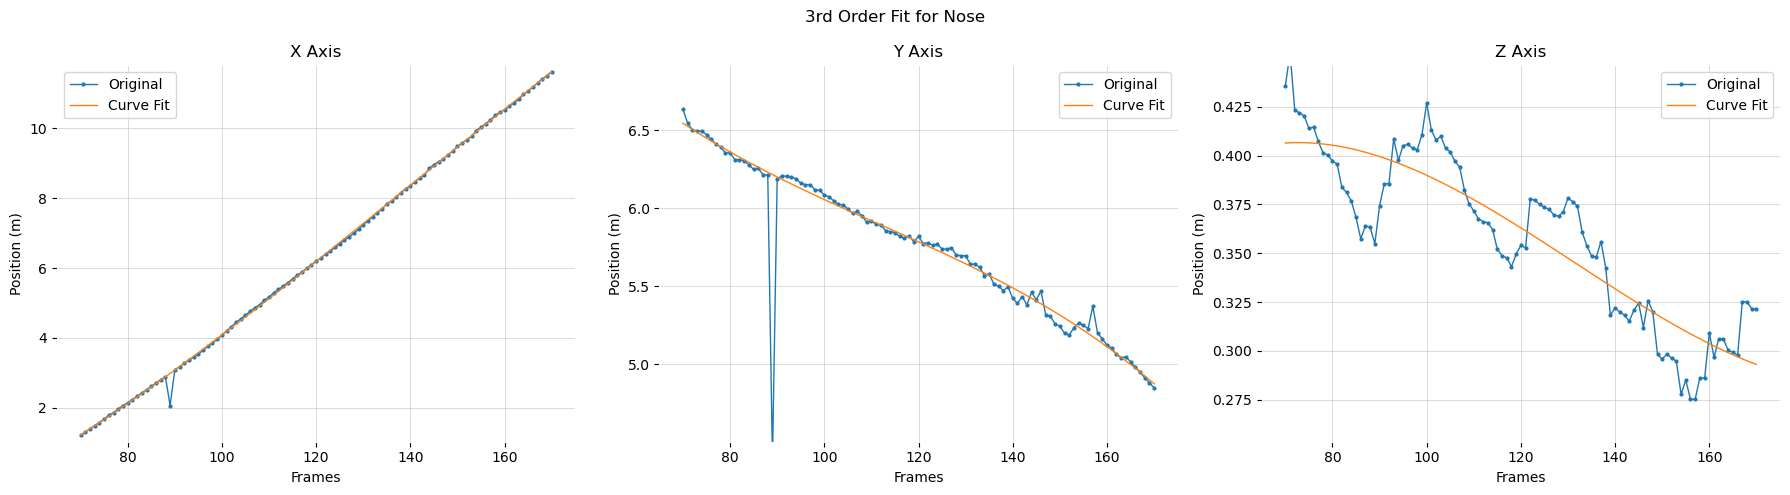

In [ ]:
t0 = time()

assert os.path.exists(DATA_DIR), f'Data directory not found: {DATA_DIR}'
OUT_DIR = os.path.join(DATA_DIR, 'fte')
DLC_DIR = os.path.join(DATA_DIR, 'dlc')
assert os.path.exists(DLC_DIR), f'DLC directory not found: {DLC_DIR}'
os.makedirs(OUT_DIR, exist_ok=True)

app.start_logging(os.path.join(OUT_DIR, 'fte.log'))

# load video info
res, fps, tot_frames, _ = app.get_vid_info(DATA_DIR) # path to original videos
assert end_frame <= tot_frames, f'end_frame must be less than or equal to {tot_frames}'
assert end_frame != 0, f'end_frame cannot be 0'
if end_frame < 0:
    end_frame = end_frame % tot_frames + 1 # cyclic

assert 0 < start_frame < tot_frames, f'start_frame must be strictly between 0 and {tot_frames}'
assert 0 <= dlc_thresh <= 1, 'dlc_thresh must be from 0 to 1'

with open(os.path.join(OUT_DIR, 'reconstruction_params.json'), 'w') as f:
    json.dump(dict(start_frame=start_frame, end_frame=end_frame, dlc_thresh=dlc_thresh), f)

start_frame -= 1 # 0 based indexing

# symbolic vars
idx       = misc.get_pose_params()
sym_list  = sp.symbols(list(idx.keys()))
positions = misc.get_3d_marker_coords(sym_list)

# ========= LAMBDIFY SYMBOLIC FUNCTIONS ========

func_map   = {'sin':pyo.sin, 'cos':pyo.cos, 'ImmutableDenseMatrix':np.array}
pose_to_3d = sp.lambdify(sym_list, positions, modules=[func_map])
pos_funcs  = []
for i in range(positions.shape[0]):
    lamb = sp.lambdify(sym_list, positions[i,:], modules=[func_map])
    pos_funcs.append(lamb)


# ========= PROJECTION FUNCTIONS ========

def pt3d_to_2d(x, y, z, K, D, R, t):
    x_2d = x*R[0,0] + y*R[0,1] + z*R[0,2] + t.flatten()[0]
    y_2d = x*R[1,0] + y*R[1,1] + z*R[1,2] + t.flatten()[1]
    z_2d = x*R[2,0] + y*R[2,1] + z*R[2,2] + t.flatten()[2]
    # project onto camera plane
    a    = x_2d/z_2d
    b    = y_2d/z_2d
    # fisheye params
    r    = (a**2 + b**2 + 1e-12)**0.5
    th   = pyo.atan(r)
    # distortion
    th_D = th * (1 + D[0]*th**2 + D[1]*th**4 + D[2]*th**6 + D[3]*th**8)
    x_P  = a*th_D/r
    y_P  = b*th_D/r
    u    = K[0,0]*x_P + K[0,2]
    v    = K[1,1]*y_P + K[1,2]
    return u, v

def pt3d_to_x2d(x, y, z, K, D, R, t):
    u = pt3d_to_2d(x, y, z, K, D, R, t)[0]
    return u

def pt3d_to_y2d(x, y, z, K, D, R, t):
    v = pt3d_to_2d(x, y, z, K, D, R, t)[1]
    return v

proj_funcs = [pt3d_to_x2d, pt3d_to_y2d]

# ========= IMPORT CAMERA & SCENE PARAMS ========

K_arr, D_arr, R_arr, t_arr, cam_res, n_cams, scene_fpath = utils.find_scene_file(DATA_DIR)
D_arr = D_arr.reshape((-1,4))
assert res == cam_res

# ========= DEFINE CONSTANTS ========

markers = misc.get_markers()

R = 5 # measurement standard deviation

Q = np.array([
    4, 7, 5,    # head position in inertial
    13, 9, 26,  # head rotation in inertial
    32, 18, 12, # neck
    43,         # front torso
    10, 53, 34, # back torso
    90, 43,     # tail_base
    118, 51,    # tail_mid
    247, 186,   # l_shoulder, l_front_knee
    194, 164,   # r_shoulder, r_front_knee
    295, 243,   # l_hip, l_back_knee
    334, 149    # r_hip, r_back_knee
], dtype=np.float64)**2  # model parameters variance

#===================================================
#                   Load in data
#===================================================

print('Loading data')

df_paths = sorted(glob(os.path.join(DLC_DIR, '*.h5')))

points_2d_df = utils.load_dlc_points_as_df(df_paths, verbose=False)
#display(points_2d_df)

#===================================================
#                   Optimisation
#===================================================

print('Initialising params & variables')
m = pyo.ConcreteModel(name = 'Cheetah from measurements')

# ===== SETS =====

N  = end_frame-start_frame # number of timesteps in trajectory
P  = len(sym_list)         # number of pose parameters
L  = len(markers)          # number of dlc labels per frame
C  = n_cams                # number of cameras
D2 = 2                     # dimensionality of measurements (image points)
D3 = 3                     # dimensionality of measurements (3d points)

m.Ts = 1.0/fps # timestep
m.N  = pyo.RangeSet(N)
m.P  = pyo.RangeSet(P)
m.L  = pyo.RangeSet(L)
m.C  = pyo.RangeSet(C)
m.D2 = pyo.RangeSet(D2)
m.D3 = pyo.RangeSet(D3)

# ======= WEIGHTS =======

# functions below are needed due to pyomo issue, see https://github.com/Pyomo/pyomo/issues/611
# When issue is solved, remove init_model_weights and change initialize = init_model_weights to initialize = 1/Q

def init_meas_weights(model, n, c, l):
    # get likelihood from df
    n_mask = points_2d_df['frame']  == n+start_frame-1
    l_mask = points_2d_df['marker'] == markers[l-1]
    c_mask = points_2d_df['camera'] == c-1
    val    = points_2d_df[n_mask & l_mask & c_mask]
    likelihood =  val['likelihood'].values[0]
    return (likelihood > dlc_thresh)/R # branchless

def init_model_weights(m, p):
    return 1/Q[p-1]

def init_measurements_df(m, n, c, l, d2):
    # get measurements from df
    n_mask = points_2d_df['frame']  == n+start_frame-1
    l_mask = points_2d_df['marker'] == markers[l-1]
    c_mask = points_2d_df['camera'] == c-1
    d_idx  = {1:'x', 2:'y'}
    val    = points_2d_df[n_mask & l_mask & c_mask]
    return val[d_idx[d2]].values[0]

m.meas_err_weight  = pyo.Param(m.N, m.C, m.L, initialize = init_meas_weights, mutable=True)
m.model_err_weight = pyo.Param(m.P, initialize = init_model_weights)
m.meas             = pyo.Param(m.N, m.C, m.L, m.D2, initialize = init_measurements_df)

# ===== MODEL VARIABLES =====

m.x           = pyo.Var(m.N, m.P) # position
m.dx          = pyo.Var(m.N, m.P) # velocity
m.ddx         = pyo.Var(m.N, m.P) # acceleration
m.poses       = pyo.Var(m.N, m.L, m.D3)
m.slack_model = pyo.Var(m.N, m.P)
m.slack_meas  = pyo.Var(m.N, m.C, m.L, m.D2, initialize=0.0)

# ===== VARIABLES INITIALIZATION =====

# estimate initial points
init_x    = np.zeros((N, P))
init_dx   = np.zeros((N, P))
init_ddx  = np.zeros((N, P))

est_nose_pos, est_nose_vel = app.initialize_marker_3d(
    points_2d_df[points_2d_df['frame'].between(start_frame, end_frame-1)],
    'nose', K_arr, D_arr, R_arr, t_arr, plot=True
)

init_x[:, [idx['x_0'], idx['y_0'], idx['z_0']]] = est_nose_pos
init_dx[:, [idx['x_0'], idx['y_0'], idx['z_0']]] = est_nose_vel # head x & y velocity in inertial
init_x[:, idx['psi_0']] = np.arctan2(est_nose_vel[:, 1], est_nose_vel[:, 0]) # psi = yaw

for n in m.N:
    for p in m.P:
        m.x[n,p].value   = init_x[n-1,p-1]
        m.dx[n,p].value  = init_dx[n-1,p-1]
        m.ddx[n,p].value = init_ddx[n-1,p-1]
        # to init using last known value, use m.x[n,p].value = init_x[-1,p-1]
    # init pose
    var_list = [m.x[n,p].value for p in m.P]
    for l in m.L:
        [pos] = pos_funcs[l-1](*var_list)
        for d3 in m.D3:
            m.poses[n,l,d3].value = pos[d3-1]

# ===== CONSTRAINTS =====

print('Defining constraints')

# NOTE: 1 based indexing for pyomo!!!!...@#^!@#&
for state in idx:
    idx[state] += 1

#===== POSE CONSTRAINTS =====

print('- Pose')

def pose_constraint(m,n,l,d3):
    var_list = [m.x[n,p] for p in m.P]
    [pos] = pos_funcs[l-1](*var_list) # get 3d points
    return pos[d3-1] == m.poses[n,l,d3]

m.pose_constraint = pyo.Constraint(m.N, m.L, m.D3, rule = pose_constraint)

# define these constraint functions in a loop?
# head
def head_phi_0(m,n):
    return abs(m.x[n,idx['phi_0']]) <= np.pi/6
def head_theta_0(m,n):
    return abs(m.x[n,idx['theta_0']]) <= np.pi/6

# neck
def neck_phi_1(m,n):
    return abs(m.x[n,idx['phi_1']]) <= np.pi/6
def neck_theta_1(m,n):
    return abs(m.x[n,idx['theta_1']]) <= np.pi/6
def neck_psi_1(m,n):
    return abs(m.x[n,idx['psi_1']]) <= np.pi/6

# front torso
def front_torso_theta_2(m,n):
    return abs(m.x[n,idx['theta_2']]) <= np.pi/6

# back torso
def back_torso_theta_3(m,n):
    return abs(m.x[n,idx['theta_3']]) <= np.pi/6
def back_torso_phi_3(m,n):
    return abs(m.x[n,idx['phi_3']]) <= np.pi/6
def back_torso_psi_3(m,n):
    return abs(m.x[n,idx['psi_3']]) <= np.pi/6

# tail base
def tail_base_theta_4(m,n):
    return abs(m.x[n,idx['theta_4']]) <= np.pi/1.5
def tail_base_psi_4(m,n):
    return abs(m.x[n,idx['psi_4']]) <= np.pi/1.5

# tail mid
def tail_mid_theta_5(m,n):
    return abs(m.x[n,idx['theta_5']]) <= np.pi/1.5
def tail_mid_psi_5(m,n):
    return abs(m.x[n,idx['psi_5']]) <= np.pi/1.5

# front left leg
def l_shoulder_theta_6(m,n):
    return abs(m.x[n,idx['theta_6']]) <= np.pi/2
def l_front_knee_theta_7(m,n):
    return abs(m.x[n,idx['theta_7']] + np.pi/2) <= np.pi/2

# front right leg
def r_shoulder_theta_8(m,n):
    return abs(m.x[n,idx['theta_8']]) <= np.pi/2
def r_front_knee_theta_9(m,n):
    return abs(m.x[n,idx['theta_9']] + np.pi/2) <= np.pi/2

# back left leg
def l_hip_theta_10(m,n):
    return abs(m.x[n,idx['theta_10']]) <= np.pi/2
def l_back_knee_theta_11(m,n):
    return abs(m.x[n,idx['theta_11']] - np.pi/2) <= np.pi/2

# back right leg
def r_hip_theta_12(m,n):
    return abs(m.x[n,idx['theta_12']]) <= np.pi/2
def r_back_knee_theta_13(m,n):
    return abs(m.x[n,idx['theta_13']] - np.pi/2) <= np.pi/2

m.head_phi_0           = pyo.Constraint(m.N, rule = head_phi_0)
m.head_theta_0         = pyo.Constraint(m.N, rule = head_theta_0)
m.neck_phi_1           = pyo.Constraint(m.N, rule = neck_phi_1)
m.neck_theta_1         = pyo.Constraint(m.N, rule = neck_theta_1)
m.neck_psi_1           = pyo.Constraint(m.N, rule = neck_psi_1)
m.front_torso_theta_2  = pyo.Constraint(m.N, rule = front_torso_theta_2)
m.back_torso_theta_3   = pyo.Constraint(m.N, rule = back_torso_theta_3)
m.back_torso_phi_3     = pyo.Constraint(m.N, rule = back_torso_phi_3)
m.back_torso_psi_3     = pyo.Constraint(m.N, rule = back_torso_psi_3)
m.tail_base_theta_4    = pyo.Constraint(m.N, rule = tail_base_theta_4)
m.tail_base_psi_4      = pyo.Constraint(m.N, rule = tail_base_psi_4)
m.tail_mid_theta_5     = pyo.Constraint(m.N, rule = tail_mid_theta_5)
m.tail_mid_psi_5       = pyo.Constraint(m.N, rule = tail_mid_psi_5)
m.l_shoulder_theta_6   = pyo.Constraint(m.N, rule = l_shoulder_theta_6)
m.l_front_knee_theta_7 = pyo.Constraint(m.N, rule = l_front_knee_theta_7)
m.r_shoulder_theta_8   = pyo.Constraint(m.N, rule = r_shoulder_theta_8)
m.r_front_knee_theta_9 = pyo.Constraint(m.N, rule = r_front_knee_theta_9)
m.l_hip_theta_10       = pyo.Constraint(m.N, rule = l_hip_theta_10)
m.l_back_knee_theta_11 = pyo.Constraint(m.N, rule = l_back_knee_theta_11)
m.r_hip_theta_12       = pyo.Constraint(m.N, rule = r_hip_theta_12)
m.r_back_knee_theta_13 = pyo.Constraint(m.N, rule = r_back_knee_theta_13)

# ===== MEASUREMENT CONSTRAINTS =====

print('- Measurement')

def measurement_constraints(m, n, c, l, d2):
    # project
    K, D, R, t = K_arr[c-1], D_arr[c-1], R_arr[c-1], t_arr[c-1]
    x, y, z    = m.poses[n,l,idx['x_0']], m.poses[n,l,idx['y_0']], m.poses[n,l,idx['z_0']]
    return proj_funcs[d2-1](x, y, z, K, D, R, t) - m.meas[n, c, l, d2] - m.slack_meas[n, c, l, d2] == 0

m.measurement = pyo.Constraint(m.N, m.C, m.L, m.D2, rule = measurement_constraints)

# ===== INTEGRATION CONSTRAINTS =====

print('- Numerical integration')

def backwards_euler_pos(m,n,p):
    return m.x[n,p] == m.x[n-1,p] + m.Ts*m.dx[n,p] if n > 1 else pyo.Constraint.Skip

def backwards_euler_vel(m,n,p):
    return m.dx[n,p] == m.dx[n-1,p] + m.Ts*m.ddx[n,p] if n > 1 else pyo.Constraint.Skip

def constant_acc(m, n, p):
    return m.ddx[n,p] == m.ddx[n-1,p] + m.slack_model[n,p] if n > 1 else pyo.Constraint.Skip

m.integrate_p  = pyo.Constraint(m.N, m.P, rule = backwards_euler_pos)
m.integrate_v  = pyo.Constraint(m.N, m.P, rule = backwards_euler_vel)
m.constant_acc = pyo.Constraint(m.N, m.P, rule = constant_acc)

# ======= OBJECTIVE FUNCTION =======

print('Defining objective function')

def obj(m):
    slack_model_err, slack_meas_err = 0.0, 0.0
    for n in m.N:
        # model error
        for p in m.P:
            slack_model_err += m.model_err_weight[p] * m.slack_model[n, p] ** 2
        # measurement error
        for l in m.L:
            for c in m.C:
                for d2 in m.D2:
                    slack_meas_err += misc.redescending_loss(m.meas_err_weight[n, c, l] * m.slack_meas[n, c, l, d2], redesc_a, redesc_b, redesc_c)
    return slack_meas_err + slack_model_err

m.obj = pyo.Objective(rule = obj)

# run the solver
opt = SolverFactory(
    'ipopt',
    # executable='./CoinIpopt/build/bin/ipopt'
)

# solver options
opt.options['tol'] = 1e-1
opt.options['print_level']  = 5
opt.options['max_iter']     = 10000
opt.options['max_cpu_time'] = 10000
opt.options['OF_print_timing_statistics'] = 'yes'
opt.options['OF_print_frequency_iter']    = 10
opt.options['OF_hessian_approximation']   = 'limited-memory'
# opt.options['linear_solver'] = 'ma86'

t1 = time()
print(f'\nInitialization took {t1-t0:.2f} seconds\n')

t0 = time()
results = opt.solve(m, tee=True)
t1 = time()
print(f'\nOptimization took {t1-t0:.2f} seconds\n')

app.stop_logging()

# Save FTE results

In [ ]:
x, dx, ddx = [], [], []
for n in m.N:
    x.append([m.x[n, p].value for p in m.P])
    dx.append([m.dx[n, p].value for p in m.P])
    ddx.append([m.ddx[n, p].value for p in m.P])

app.save_fte(dict(x=x, dx=dx, ddx=ddx), OUT_DIR, scene_fpath, start_frame, dlc_thresh)

fig_fpath= os.path.join(OUT_DIR, 'fte.svg')
app.plot_cheetah_states(x, out_fpath=fig_fpath)

# Plot the cheetah!

In [ ]:
data_fpath = os.path.join(OUT_DIR, 'fte.pickle')
app.plot_cheetah_reconstruction(data_fpath, reprojections=False, centered=True, dark_mode=True)